# Hands-on: Classification of Liver With or Without Tumor on CT Images
2022 Winter 最後修改日期：2022/1/18
## CNN Classification
Dataset reference: [Medical Segmentation Decathlon](http://medicaldecathlon.com/)

## 0\. Change to GPU
開啟此 notebook 後，請先至左上角「執行階段」內點選
「變更執行階段類型」，並將硬體加速器改為「GPU」

## 1\. Prepare the Environment

In [ ]:
import os
import numpy as np
import nibabel as nib
import random
from random import shuffle, randint, seed
from collections import Counter
from tqdm.notebook import tqdm
from scipy.ndimage import zoom
from matplotlib import pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  apply_affine_transform)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

## 2\. Download the Dataset

In [ ]:
file_name = 'liver_classification.zip'
file_ids = ['1uYcfxHVrMVMMm8jqEXOP5K_nVxoi98FA', '15yMd55OAwlrLZ1LQjWUFNfPSomFKWiMV', \
            '1ZyMkwx539ga3Q1S4L7J3CL0-p3-0816R', '1tncb4IdNLhQlrsbG89uqqZ9mnDqG90jp', \
            '1oEcJFInFIlY51js8f7OKJ6PwVpaFDQJO', '1ZKTz1bn-INYt6bLnrbREfSU_WA3-cj4r', \
            '1jcb5vgTTAbCTb9Do4curdw_53A2iw4hg', '1WiiqF6OZ7qAgKvx0vMCyEnfmZfyQVPWu', \
            '1kaw7VquB1dvnHVDvD_ZTcjgQFe12aDtr']
file_index = randint(0, 8)

if not os.path.exists(file_name):
  print(f'Downloading file with index {file_index}')
  !gdown --id {file_ids[file_index]} -O {file_name}
else:
  print("Data already exist!")

Downloading...
From: https://drive.google.com/uc?id=1uYcfxHVrMVMMm8jqEXOP5K_nVxoi98FA
To: /content/liver_classification.zip
100% 1.67G/1.67G [00:11<00:00, 149MB/s]


In [ ]:
# unzip the file
if not os.path.exists("./liver_classification") and os.path.exists(file_name):
  !unzip liver_classification.zip
else:
  print("Zip file doesn't exist or has been unzipped" )

Archive:  liver_classification.zip
   creating: liver_classification/
   creating: liver_classification/crop_image/
  inflating: liver_classification/crop_image/liver_110.nii.gz  
  inflating: liver_classification/crop_image/liver_67.nii.gz  
  inflating: liver_classification/crop_image/liver_40.nii.gz  
  inflating: liver_classification/crop_image/liver_7.nii.gz  
  inflating: liver_classification/crop_image/liver_126.nii.gz  
  inflating: liver_classification/crop_image/liver_24.nii.gz  
  inflating: liver_classification/crop_image/liver_100.nii.gz  
  inflating: liver_classification/crop_image/liver_76.nii.gz  
  inflating: liver_classification/crop_image/liver_48.nii.gz  
  inflating: liver_classification/crop_image/liver_30.nii.gz  
  inflating: liver_classification/crop_image/liver_114.nii.gz  
  inflating: liver_classification/crop_image/liver_21.nii.gz  
  inflating: liver_classification/crop_image/liver_61.nii.gz  
  inflating: liver_classification/crop_image/liver_56.nii.gz  

## 3\. Import and View the Data


### 3-1. Check the dataset
Let's check the amount of images we have.

In [ ]:
# Set the path
data_dir = './liver_classification'
image_dir = os.path.join(data_dir, 'crop_image')
label_dir = os.path.join(data_dir, 'crop_label')

In [ ]:
# Check how much data we have
print("Number of images:", len(os.listdir(image_dir)))
print("Number of labels:", len(os.listdir(label_dir)))

Number of images: 130
Number of labels: 130


We have 130 pairs of CT images and labels.

### 3-2. Separate the images
Then, we need to split the 130 data into training, validation, and testing sets. \
You can decide the amount of each set.

In [ ]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Separate data into training, validation, and testing set
total_file_list = os.listdir(image_dir)
shuffle(total_file_list)

############### change here #################
# number of data for train, valid, test
data_n = [78, 26, 26] 
############### change here #################

assert sum(data_n) == len(total_file_list), 'Invalid split'
train_n, valid_n, test_n = data_n

train_list = total_file_list[:train_n]
valid_list = total_file_list[train_n:train_n+valid_n]
test_list = total_file_list[train_n + valid_n:train_n + valid_n + test_n]
print("{} data for training, list: {}".format(len(train_list), train_list))
print("{} data for validation, list: {}".format(len(valid_list), valid_list))
print("{} data for testing, list: {}".format(len(test_list), test_list))

78 data for training, list: ['liver_81.nii.gz', 'liver_84.nii.gz', 'liver_111.nii.gz', 'liver_98.nii.gz', 'liver_23.nii.gz', 'liver_40.nii.gz', 'liver_71.nii.gz', 'liver_4.nii.gz', 'liver_113.nii.gz', 'liver_101.nii.gz', 'liver_119.nii.gz', 'liver_33.nii.gz', 'liver_16.nii.gz', 'liver_129.nii.gz', 'liver_1.nii.gz', 'liver_87.nii.gz', 'liver_53.nii.gz', 'liver_35.nii.gz', 'liver_55.nii.gz', 'liver_31.nii.gz', 'liver_122.nii.gz', 'liver_92.nii.gz', 'liver_34.nii.gz', 'liver_27.nii.gz', 'liver_82.nii.gz', 'liver_28.nii.gz', 'liver_110.nii.gz', 'liver_9.nii.gz', 'liver_86.nii.gz', 'liver_2.nii.gz', 'liver_90.nii.gz', 'liver_11.nii.gz', 'liver_6.nii.gz', 'liver_88.nii.gz', 'liver_19.nii.gz', 'liver_38.nii.gz', 'liver_21.nii.gz', 'liver_126.nii.gz', 'liver_72.nii.gz', 'liver_14.nii.gz', 'liver_57.nii.gz', 'liver_12.nii.gz', 'liver_47.nii.gz', 'liver_70.nii.gz', 'liver_48.nii.gz', 'liver_63.nii.gz', 'liver_58.nii.gz', 'liver_24.nii.gz', 'liver_105.nii.gz', 'liver_39.nii.gz', 'liver_97.nii.gz'

### 3-3. Load and preprocess the images
After we separate the data, we have to load the data and perform preprocessing in order to 


1.   adjust the format of data to fit into the model
2.   perform image processing to avoid useless information


The function below perform data preprocessing. \
The preprocessing includes: 

*   **Cropping**: remove the region outside the bounding box of the liver. 
*   **Resampling**: zoom the image to a specific shape. The input shape of our model is (224, 224) (you can find it when importing the model), so we have to resample the image into (224, 224).
*   **Windowing**: adjust the brightness and contrast of the image. This process only works effectively on CT images. You can adjust the value for different window width and window level.
*   **Normalization**: change the value on each pixel to value between 0 and 1.
*   **Masking**: change the region outside liver to 0. 


In [ ]:
img_path = image_dir + '/' + train_list[0]
lbl_path = label_dir + '/' + train_list[0]
original_image = nib.load(img_path).get_fdata()[:,:,10]
original_label = nib.load(lbl_path).get_fdata()[:,:,10]

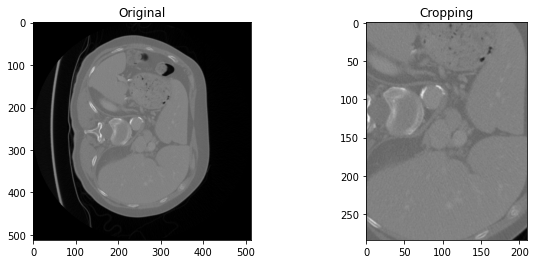

In [ ]:
def cropping(image, label):
  x_min = np.min(np.where(label != 0)[0])
  x_max = np.max(np.where(label != 0)[0])
  y_min = np.min(np.where(label != 0)[1])
  y_max = np.max(np.where(label != 0)[1])
  image = image[x_min:x_max, y_min:y_max]
  label = label[x_min:x_max, y_min:y_max]
  return image, label

cropped_image, cropped_label = cropping(original_image, original_label)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(original_image, cmap='gray',)
axis[0].set_title('Original')

axis[1].imshow(cropped_image, cmap='gray')
axis[1].set_title('Cropping')

plt.show()

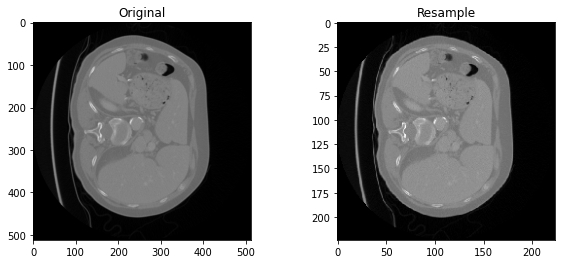

In [ ]:
def resample(image, label, output_shape=(224, 224)):
  resize_factor_x = output_shape[0] / np.shape(image)[0]
  resize_factor_y = output_shape[1] / np.shape(image)[1]
  image = zoom(image, (resize_factor_x, resize_factor_y), order=0, mode='nearest')
  label = zoom(label, (resize_factor_x, resize_factor_y), order=0, mode='nearest')
  return image, label

resampled_image, resampled_label = resample(original_image, original_label)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(original_image, cmap='gray')
axis[0].set_title('Original')

axis[1].imshow(resampled_image, cmap='gray')
axis[1].set_title('Resample')

plt.show()

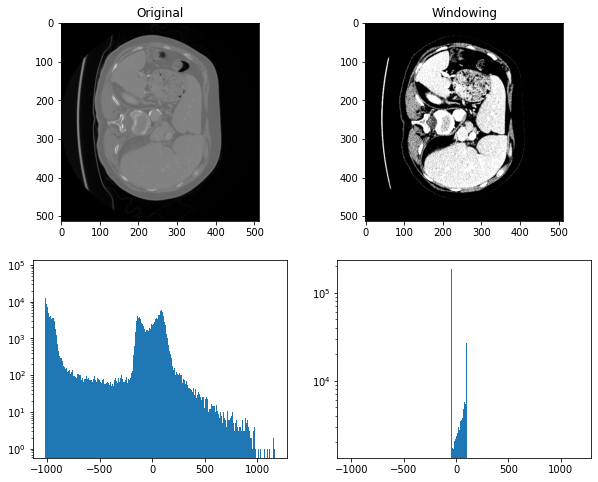

In [ ]:
def windowing(image, lower, upper):
  return np.clip(image, lower, upper)

############### change here #################
window_range = [-50, 100]
############### change here #################

windowed_image = windowing(original_image, window_range[0], window_range[1])

fig, axis = plt.subplots(2, 2, figsize=(10, 8))

axis[0, 0].imshow(original_image, cmap='gray')
axis[0, 0].set_title('Original')

axis[0, 1].imshow(windowed_image, cmap='gray')
axis[0, 1].set_title('Windowing')

counts, bins = np.histogram(original_image, bins=256)
axis[1, 0].hist(bins[:-1], bins=256, weights=counts, log=True)

counts, bins = np.histogram(windowed_image, bins=256)
axis[1, 1].hist(bins[:-1], bins=256, weights=counts, log=True, \
                range=(original_image.min(), original_image.max()))

plt.show()

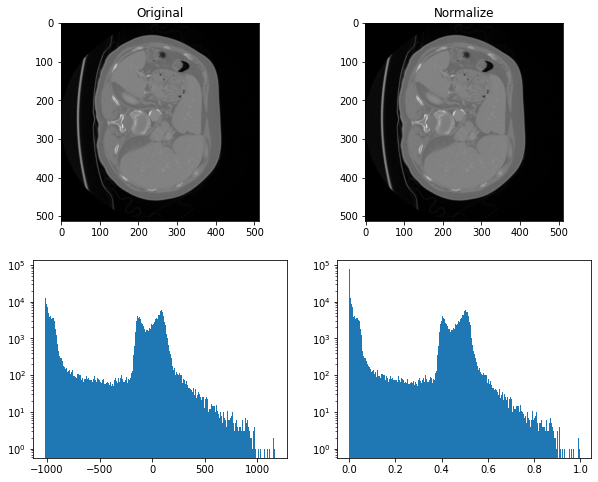

Range of original image = [-1024.0, 1180.0]
Range of normalized image = [0.0, 1.0]


In [ ]:
#from matplotlib.colors import Normalize
def normalize(image):
  return (image - np.min(image))/(np.max(image) - np.min(image))

normalized_image = normalize(original_image)

fig, axis = plt.subplots(2, 2, figsize=(10, 8))
axis[0, 0].imshow(original_image, cmap='gray')
axis[0, 0].set_title('Original')

axis[0, 1].imshow(normalized_image, cmap='gray')
axis[0, 1].set_title('Normalize')

counts, bins = np.histogram(original_image, bins=256)
axis[1, 0].hist(bins[:-1], bins=256, weights=counts, log=True)

counts, bins = np.histogram(normalized_image, bins=256)
axis[1, 1].hist(bins[:-1], bins=256, weights=counts, log=True)

plt.show()
print(f'Range of original image = [{np.min(original_image)}, {np.max(original_image)}]')
print(f'Range of normalized image = [{np.min(normalized_image)}, {np.max(normalized_image)}]')

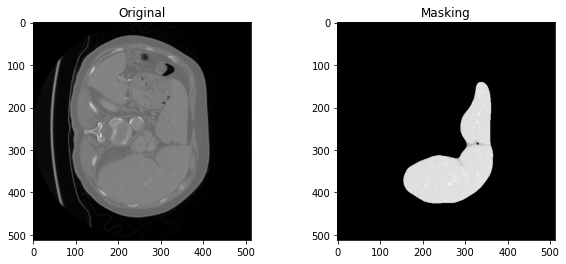

In [ ]:
def masking(image, label):
  image = np.copy(image)
  image[np.where(label == 0)] = image.min()
  return image

masked_image = masking(original_image, original_label)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(original_image, cmap='gray')
axis[0].set_title('Original')

axis[1].imshow(masked_image, cmap='gray')
axis[1].set_title('Masking')

plt.show()

In [ ]:
# function of data loading and preprocessing
def load_data(image_dir, label_dir, file_list, output_shape=(224, 224), \
              channel=3, window_range=(-50, 200), perform_crop=True, perform_mask=True):
  X = []
  y = []
  if perform_crop:
    threshold_tumor = 0.001
    threshold_liver = 0.04
  else:
    threshold_tumor = 0.002
    threshold_liver = 0.08

  for filename in tqdm(file_list):
    ori_image = nib.load(os.path.join(image_dir, filename)).get_fdata()
    ori_label = nib.load(os.path.join(label_dir, filename)).get_fdata()
    # Preprocessing - cropping
    if perform_crop:
      x_min = np.min(np.where(ori_label != 0)[0])
      x_max = np.max(np.where(ori_label != 0)[0])
      y_min = np.min(np.where(ori_label != 0)[1])
      y_max = np.max(np.where(ori_label != 0)[1])
      ori_image = ori_image[x_min:x_max, y_min:y_max, :]
      ori_label = ori_label[x_min:x_max, y_min:y_max, :]
      
    for idx in range(ori_image.shape[2]):
      if not np.max(ori_label[:, :, idx]) == 0:
        # Preprocessing - resampling
        image_2d, label_2d = resample(ori_image[:, :, idx], ori_label[:, :, idx], output_shape=output_shape)
        # Preprocessing - windowing
        image_2d = windowing(image_2d, window_range[0], window_range[1])
        # Preprocessing - normalization
        image_2d = normalize(image_2d)
        # Preprocessing - masking
        if perform_mask:
          image_2d = masking(image_2d, label_2d)

        if np.max(label_2d) == 2 and np.count_nonzero(label_2d == 1) > output_shape[0]**2*threshold_tumor:
          X.append(image_2d)
          y.append(1)
        elif np.max(label_2d) == 1 and np.count_nonzero(label_2d == 1) > output_shape[0]**2*threshold_liver:
          X.append(image_2d)
          y.append(0)

  X = np.array(X)
  stacked_X = np.stack((X,)*channel, axis=-1)
  print("We got {} 2D images with {}".format(len(y), dict(Counter(y))))
  y = np.array(y)
  print("Done loading data with X shape = {}, y shape = {}".format(stacked_X.shape, y.shape))

  return stacked_X, y

You can adjust some parameters for preprocessing here.

In [ ]:
# Load data and perform image processing
############### change here #################
output_shape = (224, 224)
channel = 3
window_range = (-50, 200)
perform_crop = False
perform_mask = False
############### change here #################

train_X, train_y = load_data(
    image_dir, label_dir, train_list, 
    output_shape=output_shape, 
    channel=channel, 
    window_range=window_range,
    perform_crop=perform_crop, 
    perform_mask=perform_mask
)

valid_X, valid_y = load_data(
    image_dir, label_dir, valid_list, 
    output_shape=output_shape, 
    channel=channel, 
    window_range=window_range,
    perform_crop=perform_crop, 
    perform_mask=perform_mask
)

  0%|          | 0/78 [00:00<?, ?it/s]

We got 1197 2D images with {1: 791, 0: 406}
Done loading data with X shape = (1197, 224, 224, 3), y shape = (1197,)


  0%|          | 0/26 [00:00<?, ?it/s]

We got 380 2D images with {0: 200, 1: 180}
Done loading data with X shape = (380, 224, 224, 3), y shape = (380,)


### 3-4. Visualize the data
After loading the data, let's have a look at what `train_X`, `train_y`, `valid_X`, `valid_y` we got.

In [ ]:
# function of plotting data randomly
def plot_image(X, y, row, col):
  ax = []
  fig = plt.figure(figsize=(3*col, 3*row))

  for i in range(row*col):
    value = randint(0, X.shape[0]-1)
    image_plot = X[value, :, :, 0]
    ax.append(fig.add_subplot(row, col, i+1))
    ax[i].set_title("Label: {}".format(y[value]))
    plt.axis('off')
    plt.imshow(image_plot, cmap='gray')
  plt.show()

We can randomly pick some examples from training or validation sets to see the images.\
You can change how many images to show at each row or column run the code repeatly.

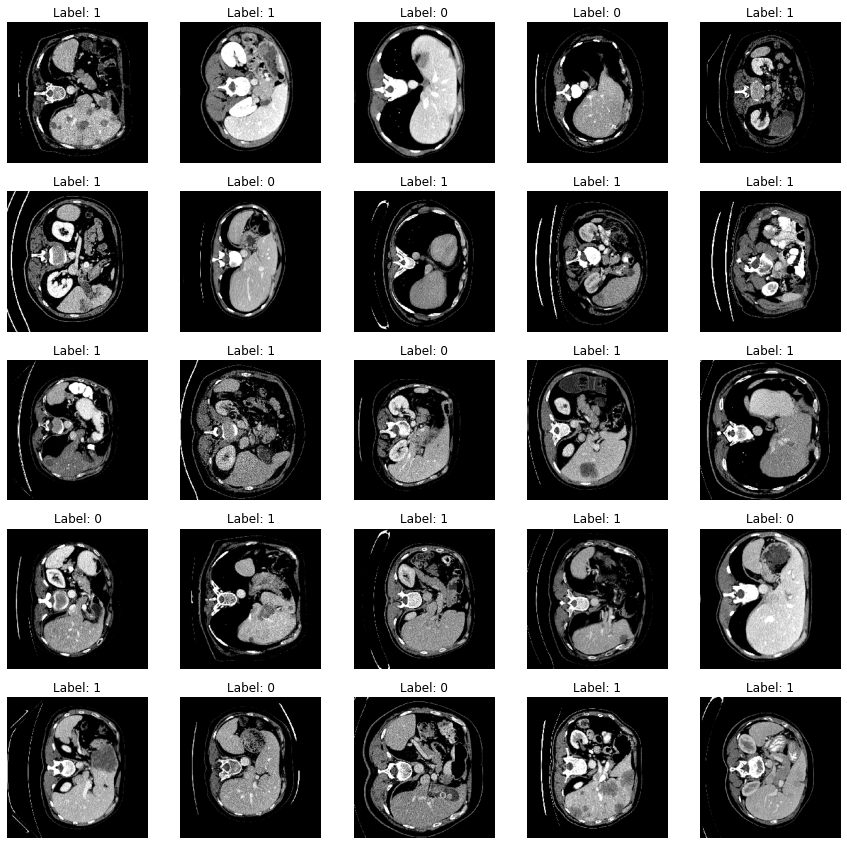

In [ ]:
############### change here #################
row = 5
col = 5
############### change here #################

plot_image(train_X, train_y, row, col)

### 3-5. Fit the data into generator with augmentation
We can perform augmentation to increase the variability of the training data. \
The augmentation includes: 

*   **Rotation**
*   **Shift**
*   **Shear**
*   **Zoom**

In [ ]:
image = train_X[10]

Rotation angle = -45.17


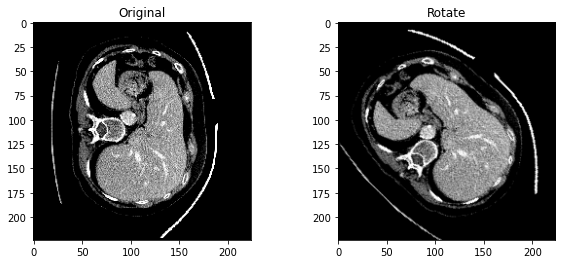

In [ ]:
############### change here #################
rotation_range = 180 # in degree
rotation_angle = np.random.uniform(-rotation_range, rotation_range)
############### change here #################

print('Rotation angle = {:.2f}'.format(rotation_angle))

aug_image = apply_affine_transform(image, theta=rotation_angle)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(image, cmap='gray')
axis[0].set_title('Original')

axis[1].imshow(aug_image, cmap='gray')
axis[1].set_title('Rotate')

plt.show()

width_shift = 45.07， height_shift = 32.48


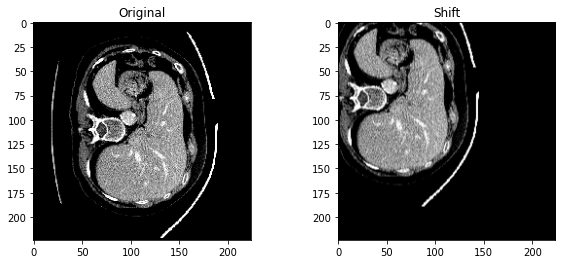

In [ ]:
############### change here #################
width_shift_range = 50.0
height_shift_range = 70.0

width_shift = np.random.uniform(-width_shift_range, width_shift_range)
height_shift = np.random.uniform(-height_shift_range, height_shift_range)
############### change here #################

if abs(width_shift) <= 1:
  width_shift *= image.shape[0]
if abs(height_shift) <= 1:
  height_shift *= image.shape[1]

print('width_shift = {:.2f}， height_shift = {:.2f}'.format(width_shift, height_shift))

aug_image = apply_affine_transform(image, tx=height_shift, ty=width_shift)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(image, cmap='gray')
axis[0].set_title('Original')

axis[1].imshow(aug_image, cmap='gray')
axis[1].set_title('Shift')

plt.show()

Shear angle = 17.76


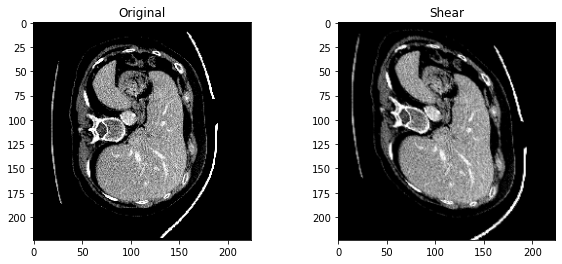

In [ ]:
############### change here #################
shear_range = 90 # in degree
shear_angle = np.random.uniform(-shear_range, shear_range)
############### change here #################

print('Shear angle = {:.2f}'.format(shear_angle))

aug_image = apply_affine_transform(image, shear=shear_angle)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(image, cmap='gray')
axis[0].set_title('Original')

axis[1].imshow(aug_image, cmap='gray')
axis[1].set_title('Shear')

plt.show()

zx = 1.25 zy = 1.25


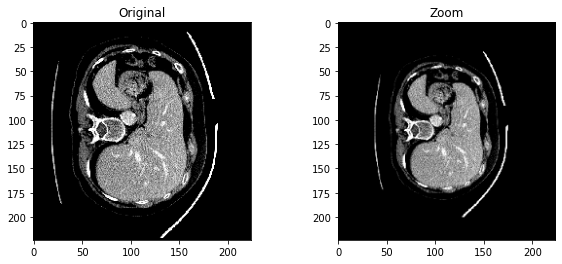

In [ ]:
############### change here #################
zoom_range = (1.2, 1.5)
############### change here #################

zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)

print('zx = {:.2f} zy = {:.2f}'.format(zx, zy))

aug_image = apply_affine_transform(image, zx=zx, zy=zy)

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
  
axis[0].imshow(image, cmap='gray')
axis[0].set_title('Original')

axis[1].imshow(aug_image, cmap='gray')
axis[1].set_title('Zoom')

plt.show()

This code shows the original parameters (aka without any augmentation). \
You can try different number. For example, setting `rotation_range`=10, `width_shift_range`=0.1, `height_shift_range`=0.1, `shear_range`=15, `zoom_range`=(0.9, 1.1) \
There's no "best" setting for deep learning. All you can do is running several experiment to find the pattern. \
You can check more detail at [ImageDataGenerator class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
# Set the augmentation parameters and fit the training data
############### change here #################
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=(1.0, 1.0),
    fill_mode="constant",
    cval=0
)
############### change here #################
datagen.fit(train_X)

## 4\. Build the Model
We finished preparing the data! \
It's time to build a CNN model for classification if the CT image contains a liver tumor or not.\
Here we use MobileNet provided by Keras Applications because this may be the fastest model. \
You can also visit [Keras Applications](https://keras.io/api/applications/) to try different model.


### 4-1. Load the model with pretrained weights

In [ ]:
from tensorflow.keras.applications import MobileNet

# Load the model and add layers for binary classification output
base_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
imagenet_weight = model.get_weights()

# Set the hyperparameters
############### change here #################
epochs = 5
batch_size = 32
lr = 1e-4
############### change here #################

# Compile the model
model.compile(
      optimizer=keras.optimizers.Adam(lr),
      loss="binary_crossentropy",
      metrics=["accuracy"],
)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
# [optional] Plot the model (method 1)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# [optional] Plot the model (method 2)
#model.summary()

### 4-2. Start training model
We start training the model here. \
Please notice that this might take a while. 


In [ ]:
model.set_weights(imagenet_weight)

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    steps_per_epoch=len(train_X)/batch_size,
    epochs=epochs,
    validation_data=(valid_X, valid_y)
)

Epoch 1/5
37/37 [==============================] - 27s 387ms/step - loss: 0.5139 - accuracy: 0.7368 - val_loss: 0.6367 - val_accuracy: 0.6263
Epoch 2/5
37/37 [==============================] - 12s 329ms/step - loss: 0.1666 - accuracy: 0.9474 - val_loss: 0.6973 - val_accuracy: 0.5763
Epoch 3/5
37/37 [==============================] - 12s 329ms/step - loss: 0.0644 - accuracy: 0.9925 - val_loss: 0.5865 - val_accuracy: 0.6763
Epoch 4/5
37/37 [==============================] - 12s 330ms/step - loss: 0.0242 - accuracy: 0.9983 - val_loss: 0.6363 - val_accuracy: 0.6789
Epoch 5/5
37/37 [==============================] - 12s 331ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.6442 - val_accuracy: 0.6789


When we finished training, we can take a look at the changes of  loss and accuracy on training and validation data during training.

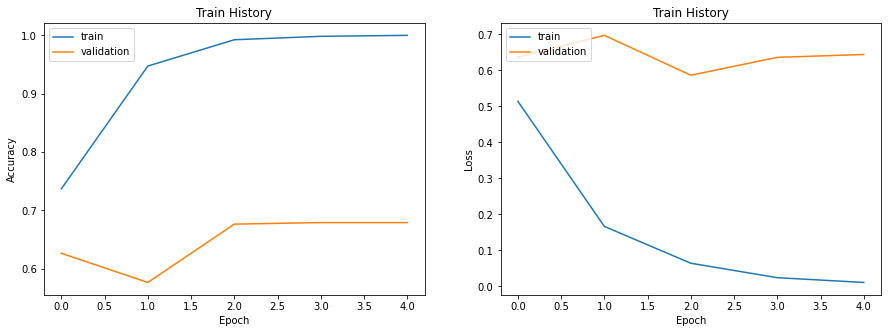

In [ ]:
# Plot loss and accuracy
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 5\. Evaluate the Test Data
We've done training the model. \
Now it's time to see how the model perform on testing data.\
Firstly, let's load the testing data using the same method when we load the training and validation data.

In [ ]:
# Load test data
test_X, test_y = load_data(
    image_dir, label_dir, test_list, 
    output_shape=output_shape, 
    channel=channel, 
    window_range=window_range,
    perform_crop=perform_crop, 
    perform_mask=perform_mask
)

  0%|          | 0/26 [00:00<?, ?it/s]

We got 425 2D images with {1: 306, 0: 119}
Done loading data with X shape = (425, 224, 224, 3), y shape = (425,)


Here we perform the trained mdoel on the test data.

In [ ]:
# Predict the test data
predict_y = model.predict(test_X)

Then, we can see the classification results.

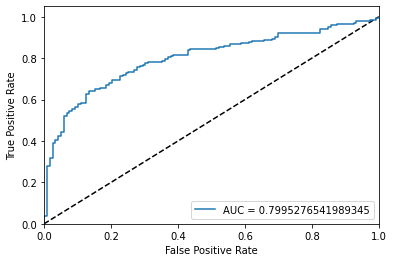

In [ ]:
# Plot the ROC curve of the test results
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, _ = roc_curve(test_y, predict_y)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))

plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We now turn the result into binary result, and make the comparison on the groundtruths by the confusion matrix.

In [ ]:
############### your code here #################
threshold = 0.5
############### your code here #################

# Print the confusion matrix of the binray classification
predict_y[predict_y >= threshold] = 1
predict_y[predict_y < threshold] = 0
cm = confusion_matrix(test_y, predict_y, labels=[1, 0])
print(cm)

[[243  63]
 [ 44  75]]


Then, we can check the sensitivity and specificity.

In [ ]:
# Calculate the sensitivity and specificity
TP = confusion_matrix(test_y, predict_y, labels=[1, 0])[0, 0]
FP = confusion_matrix(test_y, predict_y, labels=[1, 0])[1, 0]
FN = confusion_matrix(test_y, predict_y, labels=[1, 0])[0, 1]
TN = confusion_matrix(test_y, predict_y, labels=[1, 0])[1, 1]
print("True positive: {}".format(TP))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN))
print("True negative: {}".format(TN))

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

True positive: 243
False positive: 44
False negative: 63
True negative: 75
Sensitivity: 0.7941176470588235
Specificity: 0.6302521008403361
